Running K-means (Euclidean)...


C:\Users\mridu\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


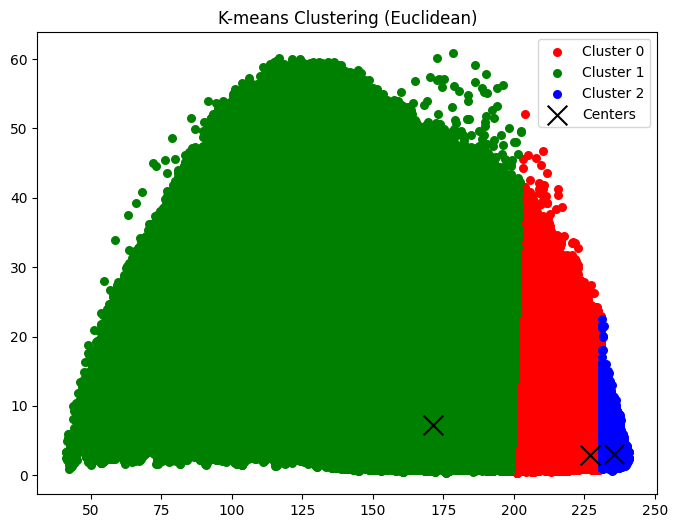

Running Modified K-means (Mahalanobis)...


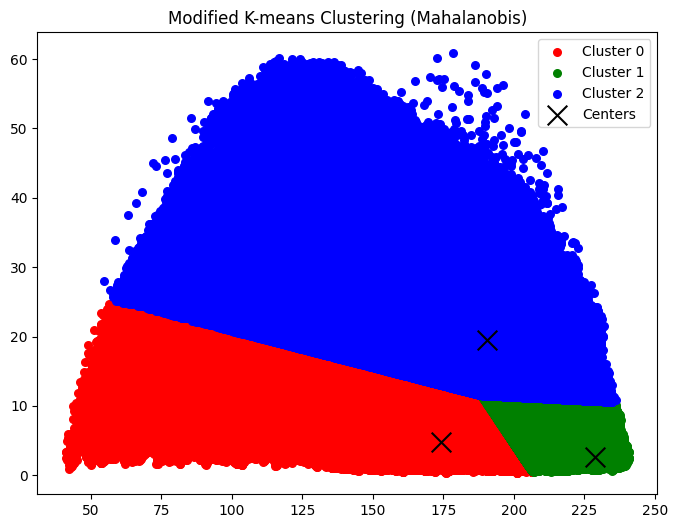

Running segmentation on test images...


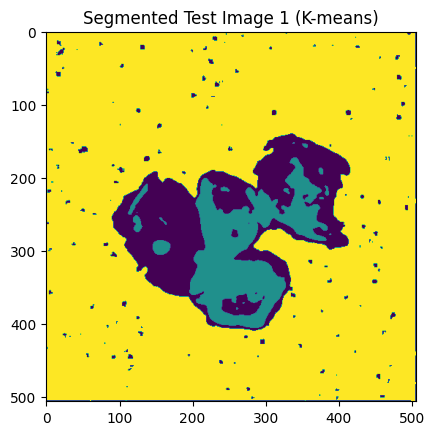

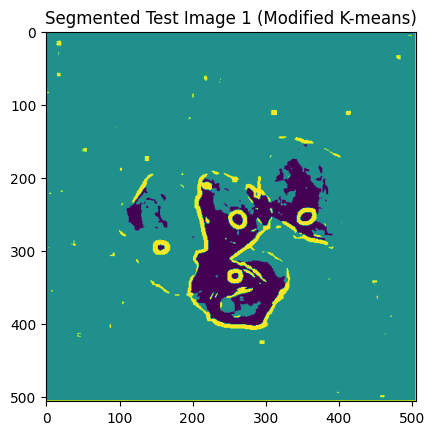

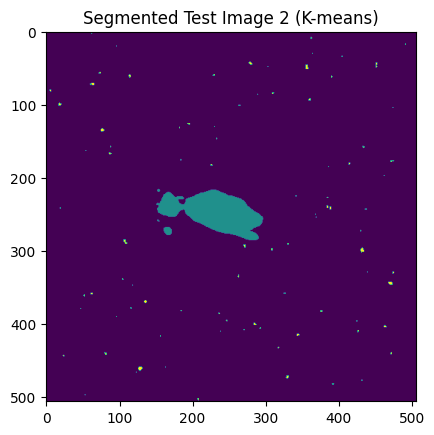

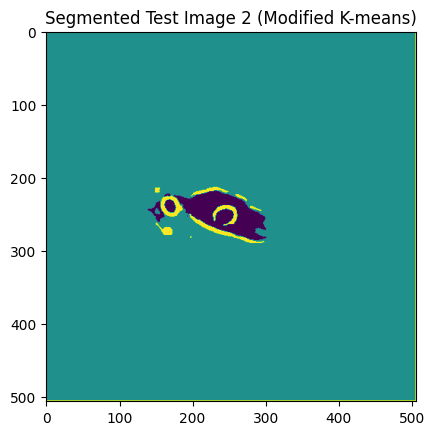

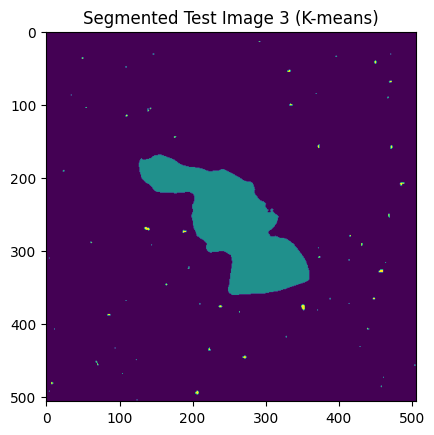

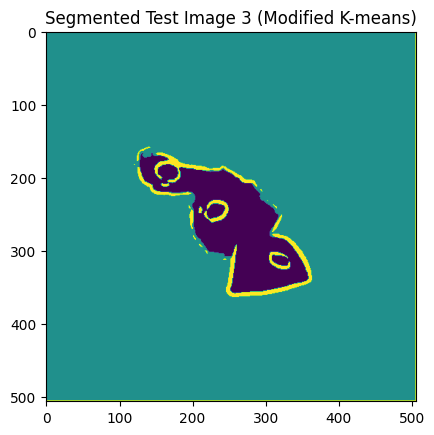

In [5]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.linalg import inv

# Helper function to calculate Euclidean distance between points and centers
def euclidean_distance(points, centers):
    return np.linalg.norm(points[:, np.newaxis] - centers, axis=2)

# Helper function to calculate Mahalanobis distance
def mahalanobis_distance(points, centers, cov_inv):
    diff = points[:, np.newaxis] - centers
    return np.sqrt(np.sum(np.dot(diff, cov_inv) * diff, axis=2))

# Optimized K-means clustering with Euclidean distance
def kmeans(X, n_clusters, max_iters=100, tol=1e-4):
    n_samples, n_features = X.shape
    # Initialize centers randomly
    centers = X[np.random.choice(n_samples, n_clusters, replace=False)]

    for iteration in range(max_iters):
        # Step 1: Calculate distances to each center (Euclidean)
        distances = euclidean_distance(X, centers)
        labels = np.argmin(distances, axis=1)

        # Step 2: Recalculate centers
        new_centers = np.array([X[labels == k].mean(axis=0) for k in range(n_clusters)])

        # Check for convergence
        if np.linalg.norm(new_centers - centers) < tol:
            break
        centers = new_centers

    return centers, labels

# Optimized K-means clustering with Mahalanobis distance
def modified_kmeans(X, n_clusters, max_iters=100, tol=1e-4):
    n_samples, n_features = X.shape
    # Initialize centers randomly
    centers = X[np.random.choice(n_samples, n_clusters, replace=False)]

    # Precompute covariance matrix inverse
    cov_matrix = np.cov(X.T)
    cov_inv = inv(cov_matrix)

    for iteration in range(max_iters):
        # Step 1: Calculate distances to each center (Mahalanobis)
        distances = mahalanobis_distance(X, centers, cov_inv)
        labels = np.argmin(distances, axis=1)

        # Step 2: Recalculate centers
        new_centers = np.array([X[labels == k].mean(axis=0) for k in range(n_clusters)])

        # Check for convergence
        if np.linalg.norm(new_centers - centers) < tol:
            break
        centers = new_centers

    return centers, labels

# Function to extract patches and features from an image
def extract_patches(image, patch_size=7, shift=1):
    height, width = image.shape
    feature_vectors = []
    for i in range(0, height - patch_size + 1, shift):
        for j in range(0, width - patch_size + 1, shift):
            patch = image[i:i+patch_size, j:j+patch_size]
            mean_intensity = np.mean(patch)
            std_intensity = np.std(patch)
            feature_vectors.append([mean_intensity, std_intensity])
    return np.array(feature_vectors)

# Function to load images from a folder and extract patches along with their dimensions
def load_images_and_extract_features(folder):
    feature_vectors = []
    image_dimensions = []

    for filename in os.listdir(folder):
        if filename.endswith(".png") or filename.endswith(".jpg"):  # Add any other formats as needed
            filepath = os.path.join(folder, filename)
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale images
            patches = extract_patches(image)
            feature_vectors.append(patches)
            image_dimensions.append(image.shape)  # Store the dimensions of each image

    return feature_vectors, image_dimensions

# Function to plot the clusters and the cluster centers
def plot_clusters(X, labels, centers, title):
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(labels)
    colors = ['r', 'g', 'b']

    # Plot each cluster
    for i, label in enumerate(unique_labels):
        cluster_points = X[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=30, color=colors[i], label=f'Cluster {label}')

    # Plot the cluster centers
    plt.scatter(centers[:, 0], centers[:, 1], s=200, color='k', marker='x', label='Centers')
    plt.title(title)
    plt.legend()
    plt.show()

# Main function to run the entire process
def run_clustering(train_folder, test_folder):
    # Load and extract features from training images
    training_features, _ = load_images_and_extract_features(train_folder)
    training_features = np.vstack(training_features)  # Stack features from all training images

    # Perform K-means clustering (Euclidean)
    print("Running K-means (Euclidean)...")
    kmeans_centers, kmeans_labels = kmeans(training_features, n_clusters=3)
    plot_clusters(training_features, kmeans_labels, kmeans_centers, 'K-means Clustering (Euclidean)')

    # Perform Modified K-means clustering (Mahalanobis)
    print("Running Modified K-means (Mahalanobis)...")
    modified_centers, modified_labels = modified_kmeans(training_features, n_clusters=3)
    plot_clusters(training_features, modified_labels, modified_centers, 'Modified K-means Clustering (Mahalanobis)')

    # Segmentation on test images
    test_features, test_dimensions = load_images_and_extract_features(test_folder)

    print("Running segmentation on test images...")

    for i, features in enumerate(test_features):
        height, width = test_dimensions[i]

        # Segment with K-means (Euclidean)
        test_labels = np.argmin(euclidean_distance(features, kmeans_centers), axis=1)
        segmented_image = test_labels.reshape((height - 6, width - 6))  # Adjusting for patch size
        plt.imshow(segmented_image, cmap='viridis')
        plt.title(f'Segmented Test Image {i+1} (K-means)')
        plt.show()

        # Segment with Modified K-means (Mahalanobis)
        test_labels = np.argmin(mahalanobis_distance(features, modified_centers, inv(np.cov(features.T))), axis=1)
        segmented_image = test_labels.reshape((height - 6, width - 6))  # Adjusting for patch size
        plt.imshow(segmented_image, cmap='viridis')
        plt.title(f'Segmented Test Image {i+1} (Modified K-means)')
        plt.show()

# Set paths to your training and test image folders
train_folder = 'cell data set/Train'  # Replace with actual path
test_folder = 'cell data set/Test'  # Replace with actual path

# Run the clustering and segmentation process
run_clustering(train_folder, test_folder)
